In [26]:
!pip install mlflow
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 16.3 MB/s eta 0:00:00


In [27]:
import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass

In [28]:
# Define the MLflow tracking URI with SQLite
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

# Start the MLflow server using subprocess
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI, "--port", "5000"])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'sqli...>

In [29]:
# Set MLflow tracking URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Set or create an experiment
mlflow.set_experiment("AQI Feature Selection")

2025/07/03 00:05:11 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/03 00:05:11 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/07/03 00:05:11 INFO mlflow.tracking.fluent: Experiment with name 'AQI Feature Selection' does not exist. Creating a new experiment.


<Experiment: artifact_location='/content/mlruns/1', creation_time=1751501111108, experiment_id='1', last_update_time=1751501111108, lifecycle_stage='active', name='AQI Feature Selection', tags={}>

In [30]:
# Set up ngrok for exposing the MLflow UI
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()

# Expose the MLflow UI on port 5000
port = 5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel "{public_url}" -> "http://127.0.0.1:{port}"')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········
 * ngrok tunnel "https://9534-35-227-155-103.ngrok-free.app" -> "http://127.0.0.1:5000"


In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.3 MB/s eta 0:00:00


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [9]:
df = pd.read_csv("/content/full_preprocessed_aqi_weather_data_with_lags.csv")

In [13]:
# features and target
target = "aqi_us"
excluded_cols = ["aqi_us", "datetime"]  # you may also test with or without lag features
features = [col for col in df.columns if col not in excluded_cols]

X = df[features]
y = df[target]

In [14]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# CV for Random Forest

rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [6, 12, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

In [16]:
print("✅ Best Parameters for Random Forest:")
print(rf_grid.best_params_)

print("\n📉 Best CV MSE (neg):", rf_grid.best_score_)
print("📈 Best CV RMSE:", (-rf_grid.best_score_)**0.5)

✅ Best Parameters for Random Forest:
{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

📉 Best CV MSE (neg): -20.67764892604788
📈 Best CV RMSE: 4.54726829272783


In [17]:
# Optuna for Random Forest

def rf_objective(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }
    model = RandomForestRegressor(**rf_params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(rf_objective, n_trials=25)
best_rf_optuna = RandomForestRegressor(**rf_study.best_params, random_state=42)
best_rf_optuna.fit(X_train, y_train)

[I 2025-07-02 23:33:01,767] A new study created in memory with name: no-name-7c2aa263-f847-4b93-b55a-d87679f917c3
[I 2025-07-02 23:33:02,803] Trial 0 finished with value: 23.319851501069184 and parameters: {'n_estimators': 209, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 23.319851501069184.
[I 2025-07-02 23:33:03,567] Trial 1 finished with value: 16.950949689358886 and parameters: {'n_estimators': 138, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 16.950949689358886.
[I 2025-07-02 23:33:04,152] Trial 2 finished with value: 37.46162901060001 and parameters: {'n_estimators': 169, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 16.950949689358886.
[I 2025-07-02 23:33:05,181] Trial 3 finished with value: 29.771077189028702 and parameters: {'n_estimators': 212, 'max_depth': 6, 'min_

RandomForestRegressor(max_depth=16, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=3, n_estimators=247, random_state=42)

In [18]:
# CV for XGboost

xgb = XGBRegressor(random_state=42)
xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

In [20]:
print("✅ Best Parameters for Xgboost:")
print(xgb_grid.best_params_)

print("\n📉 Best CV MSE (neg):", xgb_grid.best_score_)
print("📈 Best CV RMSE:", (-xgb_grid.best_score_)**0.5)

✅ Best Parameters for Xgboost:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}

📉 Best CV MSE (neg): -6.361647605895996
📈 Best CV RMSE: 2.522230680547677


In [21]:
# Optuna for XGboost

def xgb_objective(trial):
    xgb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0)
    }
    model = XGBRegressor(**xgb_params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=25)
best_xgb_optuna = XGBRegressor(**xgb_study.best_params, random_state=42)
best_xgb_optuna.fit(X_train, y_train)

[I 2025-07-02 23:49:06,905] A new study created in memory with name: no-name-bacc4d6a-465c-44ad-ba7a-2be47ccfc8ed
[I 2025-07-02 23:49:11,059] Trial 0 finished with value: 6.505166530609131 and parameters: {'n_estimators': 193, 'max_depth': 7, 'learning_rate': 0.02560103310015175, 'subsample': 0.9960833643175137, 'colsample_bytree': 0.900857755732041, 'gamma': 0.06883004082819333, 'reg_alpha': 0.6725514327483438, 'reg_lambda': 0.4845532519327701}. Best is trial 0 with value: 6.505166530609131.
[I 2025-07-02 23:49:11,487] Trial 1 finished with value: 5.848228454589844 and parameters: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.276152133814367, 'subsample': 0.7925581929893469, 'colsample_bytree': 0.796959575310974, 'gamma': 0.7984322955931691, 'reg_alpha': 0.3392150138979275, 'reg_lambda': 0.09034829265176292}. Best is trial 1 with value: 5.848228454589844.
[I 2025-07-02 23:49:12,541] Trial 2 finished with value: 5.258772373199463 and parameters: {'n_estimators': 165, 'max_de

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8842366728297926, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.6256076421983944,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1336393974465606,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=245, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [22]:
# Extract feature importances
rf_importances = pd.Series(best_rf_optuna.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:15]
xgb_importances = pd.Series(best_xgb_optuna.feature_importances_, index=X_train.columns).sort_values(ascending=False)

In [23]:
# Plotting Function
def plot_importances(importances, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index, palette="viridis")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-23-78317768.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


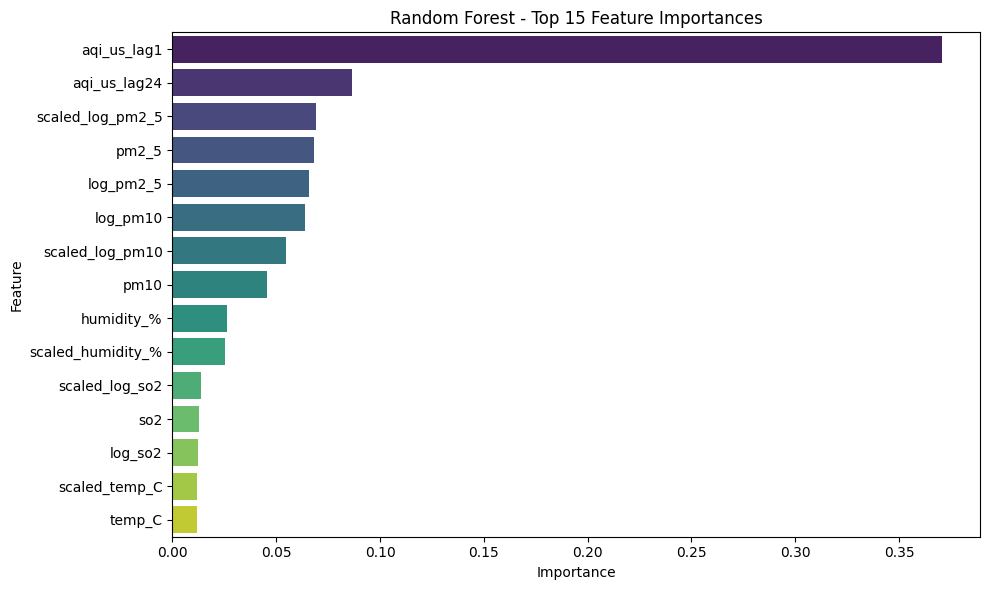

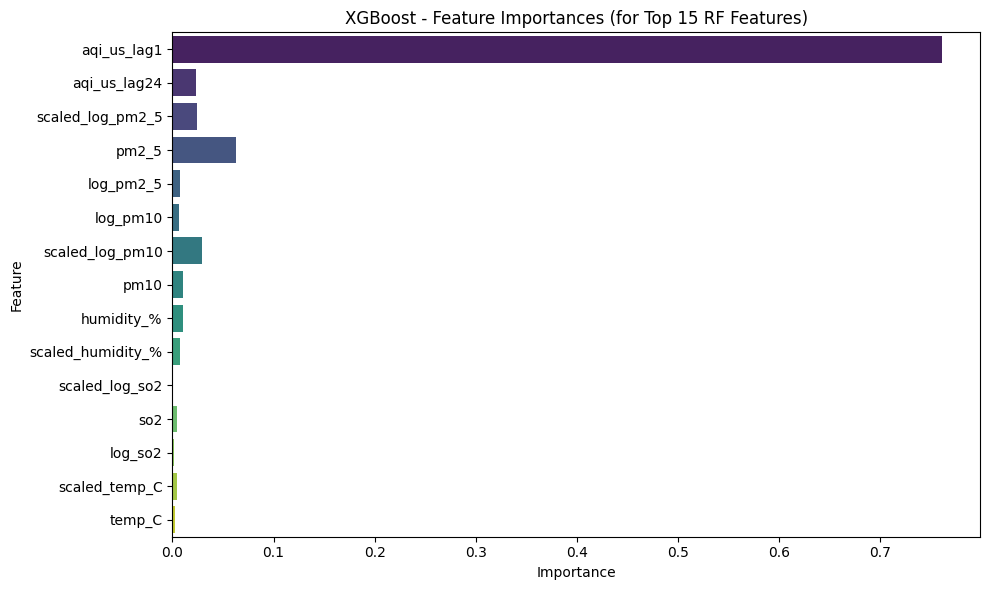

In [24]:
# Random Forest
plot_importances(rf_importances, "Random Forest - Top 15 Feature Importances")

# XGBoost
xgb_top15 = xgb_importances[rf_importances.index]
plot_importances(xgb_top15, "XGBoost - Feature Importances (for Top 15 RF Features)")

In [25]:
# Table of Importances

importance_df = pd.DataFrame({
    "Feature": rf_importances.index,
    "RandomForest_Importance": rf_importances.values,
    "XGBoost_Importance": xgb_importances[rf_importances.index].values
})

print("\n📊 Top 15 Features by Model Importance:\n")
print(importance_df.head(15).to_string(index=False))


📊 Top 15 Features by Model Importance:

          Feature  RandomForest_Importance  XGBoost_Importance
      aqi_us_lag1                 0.370454            0.760788
     aqi_us_lag24                 0.086476            0.022964
 scaled_log_pm2_5                 0.068963            0.024015
            pm2_5                 0.068007            0.062496
        log_pm2_5                 0.065638            0.007553
         log_pm10                 0.063878            0.006959
  scaled_log_pm10                 0.054836            0.029524
             pm10                 0.045496            0.010066
       humidity_%                 0.026385            0.010648
scaled_humidity_%                 0.025381            0.007474
   scaled_log_so2                 0.013888            0.000000
              so2                 0.012871            0.004640
          log_so2                 0.012417            0.001384
    scaled_temp_C                 0.011928            0.004582
           tem

In [31]:
import mlflow.sklearn
import mlflow.xgboost

# Common logging helper
def log_model_mlflow(model, model_name, params, X_test, y_test):
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_params(params)

        # Predict and log metrics
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        rmse = mse**0.5
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)

        # Log model
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, model_name)
        else:
            mlflow.sklearn.log_model(model, model_name)

        print(f"✅ Logged {model_name} to MLflow with RMSE: {rmse:.3f}")

In [32]:
# Log all 4 models

# 1. RF (CV)
log_model_mlflow(
    best_rf,
    "RandomForest_CV",
    rf_grid.best_params_,
    X_test,
    y_test
)

# 2. RF (Optuna)
log_model_mlflow(
    best_rf_optuna,
    "RandomForest_Optuna",
    rf_study.best_params,
    X_test,
    y_test
)

# 3. XGB (CV)
log_model_mlflow(
    best_xgb,
    "XGBoost_CV",
    xgb_grid.best_params_,
    X_test,
    y_test
)

# 4. XGB (Optuna)
log_model_mlflow(
    best_xgb_optuna,
    "XGBoost_Optuna",
    xgb_study.best_params,
    X_test,
    y_test
)

2025/07/03 00:12:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 00:12:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 00:12:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Logged RandomForest_CV to MLflow with RMSE: 3.239


2025/07/03 00:12:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 00:12:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Logged RandomForest_Optuna to MLflow with RMSE: 3.212


2025/07/03 00:12:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/03 00:12:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Logged XGBoost_CV to MLflow with RMSE: 1.995


2025/07/03 00:12:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged XGBoost_Optuna to MLflow with RMSE: 1.984


In [34]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Backup MLflow data to Drive
!cp -r mlruns /content/drive/MyDrive/mlflow_backup/
!cp mlflow.db /content/drive/MyDrive/mlflow_backup/

Mounted at /content/drive


In [ ]:
# # Restore from Drive
# !cp -r /content/drive/MyDrive/mlflow_backup/mlruns .
# !cp /content/drive/MyDrive/mlflow_backup/mlflow.db .

# import mlflow

# # Set tracking URI to the restored local SQLite file
# mlflow.set_tracking_uri("sqlite:///mlflow.db")

# # (Optional) Re-set your experiment name if needed
# mlflow.set_experiment("AQI Feature Selection")

# import subprocess

# # Start MLflow UI server on port 5000 using the restored database
# subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "sqlite:///mlflow.db", "--port", "5000"])

# from pyngrok import ngrok, conf
# import getpass

# # Authenticate ngrok
# conf.get_default().auth_token = getpass.getpass("🔐 Enter your ngrok authtoken: ")

# # Expose port 5000
# public_url = ngrok.connect(5000)
# print(f"🌐 Access MLflow UI at: {public_url}")